# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Import some useful module

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

import os
import math

import IPython
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


# Import our Data set 

In [3]:
def attrRename(df, ticker):
        """
        Rename attributes of DataFrame
        - prepend the string "T_" to original attribute name, where T is the string of ticker
        """
        rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in df.columns.to_list() }
        
        return df.rename(columns=rename_map)

In [4]:
def getData(tickers, indx, attrs,data_dir):
        """
        Return DataFrame with data for a list of tickers plus and index
        
        Parameters
        ----------
        tickers: List
        - List of tickers
        
        indx: String
        - Ticker of index
        
        DATA_DIR: String
        - Directory of data
        
        attrs: List
        - List of data attributes to retain
        
        Returns
        -------
        DataFrame
        - attributes:
        -- each original attribute, prepended with "T_" where T is ticker or index string
        -- This is necessary to distinguish between attributes of different tickers
        """
        DATA_DIR = data_dir
        
        dateAttr = "Dt"
        
        use_cols =  attrs.copy()
        use_cols.insert(0, dateAttr)
       
        # Read the CSV files
        dfs = []
        for ticker_num, ticker in enumerate(tickers):
            ticker_file = os.path.join(DATA_DIR, "{t}.csv".format(t=ticker) )
            ticker_df = pd.read_csv(ticker_file, index_col=dateAttr, usecols=use_cols)
            
            # Rename attributes with ticker name
            ticker_df = attrRename(ticker_df, ticker)
            
            dfs.append(ticker_df)
            
              
        index_file   = os.path.join(DATA_DIR, "{t}.csv".format(t=indx) )
        index_df   = pd.read_csv(index_file, index_col=dateAttr, usecols=use_cols)
        index_df = attrRename(index_df, indx)
        
        dfs.append(index_df)
        
        data_df = pd.concat( dfs, axis=1)
       
        return data_df

In [5]:
import os

# Getting the current work directory (cwd)
thisdir = os.getcwd()

csv_list = []

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith('.csv'):
            if not file.endswith('AAPL.csv'):
                csv_list.append(file.replace('.csv',''))

# this is all the tickers except AAPL (our target) we have in our train dataset
csv_list

['CSCO',
 'V',
 'ADBE',
 'XLE',
 'INTC',
 'XLF',
 'XLP',
 'MSFT',
 'ACN',
 'XLB',
 'XLU',
 'NVDA',
 'XLV',
 'FB',
 'IBM',
 'XLY',
 'XLK',
 'SPY',
 'XLI',
 'GOOG',
 'XLRE',
 'MA',
 'CRM']

In [6]:
# Data directory
DATA_DIR = "./Data/train"

# list all the tickers we want
tickers = csv_list

# the target index we want to predict is AAPL
indx = 'AAPL'

# we are using Close price to determine our return.
attr = ['Close']

df = getData(tickers,indx,attr,DATA_DIR)

print("Date shape: ", df.shape)

Date shape:  (4277, 24)


In [7]:
df

,CSCO_Close,V_Close,ADBE_Close,XLE_Close,INTC_Close,XLF_Close,XLP_Close,MSFT_Close,ACN_Close,XLB_Close,...,IBM_Close,XLY_Close,XLK_Close,SPY_Close,XLI_Close,GOOG_Close,XLRE_Close,MA_Close,CRM_Close,AAPL_Close
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,108.063,NaN,65.563,26.563,43.500,34.650,22.750,116.563,NaN,25.969,...,116.000,30.125,55.438,145.438,28.844,NaN,NaN,NaN,NaN,111.938
2000-01-04,102.000,NaN,60.063,26.063,41.469,33.135,22.109,112.625,NaN,25.719,...,112.063,29.219,52.625,139.750,28.047,NaN,NaN,NaN,NaN,102.500
2000-01-05,101.688,NaN,61.250,26.750,41.813,32.874,22.500,113.813,NaN,26.781,...,116.000,28.859,51.844,140.000,27.922,NaN,NaN,NaN,NaN,104.000
2000-01-06,100.000,NaN,61.750,27.781,39.375,34.318,22.922,110.000,NaN,27.469,...,114.000,29.188,50.125,137.750,28.297,NaN,NaN,NaN,NaN,95.000
2000-01-07,105.875,NaN,64.750,28.078,41.000,34.887,24.375,111.438,NaN,27.453,...,113.500,30.563,51.000,145.750,29.375,NaN,NaN,NaN,NaN,99.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,30.530,78.15,105.020,76.350,36.970,23.580,52.060,63.240,117.48,50.270,...,166.710,82.450,48.970,225.710,62.990,789.91,30.33,104.71,69.87,116.520
2016-12-27,30.680,78.35,104.980,76.520,37.070,23.610,52.050,63.280,117.55,50.540,...,167.140,82.770,49.170,226.270,63.120,791.55,30.41,104.80,69.85,117.260
2016-12-28,30.420,78.30,103.770,75.690,36.630,23.370,51.730,62.990,116.61,50.030,...,166.190,82.200,48.730,224.400,62.460,785.05,30.18,103.68,69.09,116.760


# Do some data cleansing and imputation for null value

In [8]:
# good news is all the Dtypes are consistant, and we do not need to do any convertion on that.

# several tickers have a problem of large or small part of them being null value
# especially XLRE_Close, which we only have 311 non-null value, which means XLRE_Close is only being useful when we 
# predict date is no earlier than 2015

# missing value imputation by simply mean or median is not a very wise choice here, because there obviously has some 
# time dependency or pattern exist across the time horizon.

# in order not to waste data, I will try to figure out the correlation between tickers and replace the missing part of 
# a ticker by its most positive correlated ticker who has full data on entile horizon.

# However, I will start from features from only AAPL and extend features as I going deep into the project.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CSCO_Close  4277 non-null   float64
 1   V_Close     2214 non-null   float64
 2   ADBE_Close  4277 non-null   float64
 3   XLE_Close   4277 non-null   float64
 4   INTC_Close  4277 non-null   float64
 5   XLF_Close   4277 non-null   float64
 6   XLP_Close   4277 non-null   float64
 7   MSFT_Close  4277 non-null   float64
 8   ACN_Close   3888 non-null   float64
 9   XLB_Close   4277 non-null   float64
 10  XLU_Close   4277 non-null   float64
 11  NVDA_Close  4277 non-null   float64
 12  XLV_Close   4277 non-null   float64
 13  FB_Close    1163 non-null   float64
 14  IBM_Close   4277 non-null   float64
 15  XLY_Close   4277 non-null   float64
 16  XLK_Close   4277 non-null   float64
 17  SPY_Close   4277 non-null   float64
 18  XLI_Close   4277 non-null   float64
 19  GOOG_Close  3115 

In [10]:
df.describe()

,CSCO_Close,V_Close,ADBE_Close,XLE_Close,INTC_Close,XLF_Close,XLP_Close,MSFT_Close,ACN_Close,XLB_Close,...,IBM_Close,XLY_Close,XLK_Close,SPY_Close,XLI_Close,GOOG_Close,XLRE_Close,MA_Close,CRM_Close,AAPL_Close
count,4277.000000,2214.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,3888.000000,4277.000000,...,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,3115.000000,311.000000,2670.000000,3155.000000,4277.000000
mean,24.850566,113.598419,48.498101,55.254449,26.420660,35.946952,30.590050,37.732574,49.420712,33.192283,...,126.581215,40.660577,27.831023,137.798293,35.319058,348.245234,31.373579,232.000766,69.164986,170.450354
std,14.818123,59.334077,25.317162,21.123087,9.548555,10.557432,9.838706,16.336012,28.823052,9.507553,...,40.535794,17.654793,10.281050,36.072168,10.868968,187.829850,1.528738,171.478933,41.505981,173.484604
min,8.600000,42.420000,15.980000,19.800000,12.080000,9.361000,17.820000,15.150000,11.850000,16.630000,...,55.070000,16.110000,11.580000,68.110000,15.360000,49.818300,27.220000,43.900000,9.590000,13.120000
25%,18.220000,72.862500,32.250000,32.531000,20.790000,25.015000,23.400000,26.460000,26.330000,24.120000,...,91.340000,28.580000,20.540000,112.970000,27.800000,220.692800,30.330500,95.972500,39.735000,39.759000
50%,21.820000,81.875000,38.830000,57.030000,24.150000,37.325000,26.740000,29.600000,38.925000,32.780000,...,116.540000,33.440000,24.510000,129.610000,32.230000,287.183600,31.190000,189.000000,58.610000,106.745000
75%,26.290000,155.287500,59.938000,72.560000,29.920000,43.580000,35.630000,47.750000,72.355000,40.340000,...,161.820000,46.430000,33.500000,151.050000,39.520000,510.773000,32.213500,286.830000,81.440000,222.250000
max,144.375000,278.290000,163.438000,101.290000,74.875000,57.591000,55.710000,116.563000,125.400000,52.090000,...,215.800000,84.360000,64.500000,227.760000,64.050000,813.110000,34.790000,843.600000,186.370000,702.100000


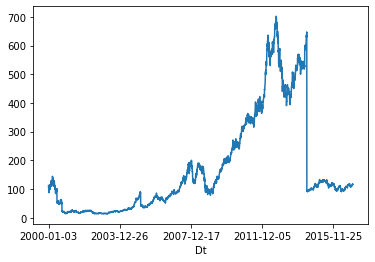

In [11]:
df['AAPL_Close'].plot()

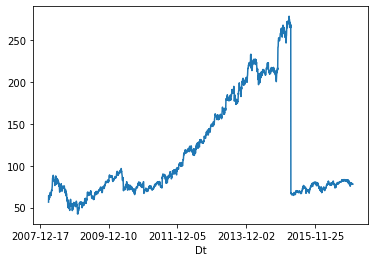

In [12]:
# V_Close starts at the end of 2007
df['V_Close'].plot()

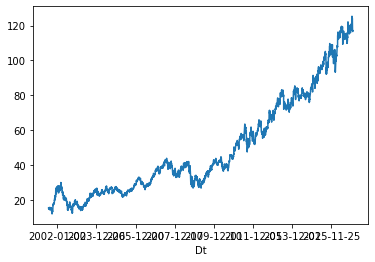

In [13]:
# ACN_Close starts at the beginning of 2002
df['ACN_Close'].plot()

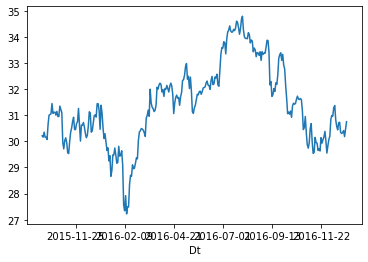

In [14]:
# ACN_Close starts at the beginning of 2015
df['XLRE_Close'].plot()

## convert price to return , which is more meaningful and comparable

In [15]:
daily_return = df.pct_change(1)
daily_return.shape

(4277, 24)

In [16]:
daily_return.describe()

,CSCO_Close,V_Close,ADBE_Close,XLE_Close,INTC_Close,XLF_Close,XLP_Close,MSFT_Close,ACN_Close,XLB_Close,...,IBM_Close,XLY_Close,XLK_Close,SPY_Close,XLI_Close,GOOG_Close,XLRE_Close,MA_Close,CRM_Close,AAPL_Close
count,4276.000000,2213.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,3887.000000,4276.000000,...,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,3114.000000,310.000000,2669.000000,3154.000000,4276.000000
mean,0.000064,0.000635,0.000605,0.000401,0.000249,0.000154,0.000237,0.000090,0.000722,0.000276,...,0.000222,0.000336,0.000104,0.000179,0.000273,0.001073,0.000118,0.001080,0.001055,0.000714
std,0.026527,0.025667,0.030590,0.017706,0.024095,0.021732,0.009475,0.021138,0.019832,0.015730,...,0.016610,0.014364,0.016545,0.012543,0.013665,0.019805,0.011071,0.028687,0.031712,0.031476
min,-0.461035,-0.750402,-0.500695,-0.144438,-0.220317,-0.460298,-0.060241,-0.483230,-0.134543,-0.124121,...,-0.155416,-0.116249,-0.086538,-0.098448,-0.094050,-0.116091,-0.052993,-0.898226,-0.754825,-0.854857
25%,-0.010327,-0.008913,-0.011721,-0.008367,-0.010886,-0.007206,-0.004710,-0.008670,-0.008343,-0.007547,...,-0.007367,-0.006399,-0.006996,-0.005344,-0.006149,-0.008108,-0.005137,-0.009140,-0.013078,-0.011358
50%,0.000243,0.000772,0.000446,0.000691,0.000382,0.000421,0.000442,0.000000,0.000445,0.000723,...,0.000132,0.000591,0.000745,0.000557,0.000661,0.000418,0.000878,0.000993,0.000000,0.000734
75%,0.011053,0.010332,0.012622,0.009874,0.011405,0.007935,0.005261,0.008950,0.009621,0.008486,...,0.007912,0.007488,0.007288,0.005928,0.007024,0.010160,0.006549,0.010698,0.014801,0.013783
max,0.243884,0.149973,0.239740,0.164747,0.201229,0.224715,0.068857,0.195652,0.163668,0.140576,...,0.120232,0.097752,0.161017,0.145198,0.107052,0.199916,0.033463,0.208463,0.191308,0.139050


In [17]:
daily_return.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CSCO_Close  4276 non-null   float64
 1   V_Close     2213 non-null   float64
 2   ADBE_Close  4276 non-null   float64
 3   XLE_Close   4276 non-null   float64
 4   INTC_Close  4276 non-null   float64
 5   XLF_Close   4276 non-null   float64
 6   XLP_Close   4276 non-null   float64
 7   MSFT_Close  4276 non-null   float64
 8   ACN_Close   3887 non-null   float64
 9   XLB_Close   4276 non-null   float64
 10  XLU_Close   4276 non-null   float64
 11  NVDA_Close  4276 non-null   float64
 12  XLV_Close   4276 non-null   float64
 13  FB_Close    1162 non-null   float64
 14  IBM_Close   4276 non-null   float64
 15  XLY_Close   4276 non-null   float64
 16  XLK_Close   4276 non-null   float64
 17  SPY_Close   4276 non-null   float64
 18  XLI_Close   4276 non-null   float64
 19  GOOG_Close  3114 

## Take a close look at the correlation between tickers

In [18]:
col_list = daily_return.columns

In [19]:
col_list

Index(['CSCO_Close', 'V_Close', 'ADBE_Close', 'XLE_Close', 'INTC_Close',
       'XLF_Close', 'XLP_Close', 'MSFT_Close', 'ACN_Close', 'XLB_Close',
       'XLU_Close', 'NVDA_Close', 'XLV_Close', 'FB_Close', 'IBM_Close',
       'XLY_Close', 'XLK_Close', 'SPY_Close', 'XLI_Close', 'GOOG_Close',
       'XLRE_Close', 'MA_Close', 'CRM_Close', 'AAPL_Close'],
      dtype='object')

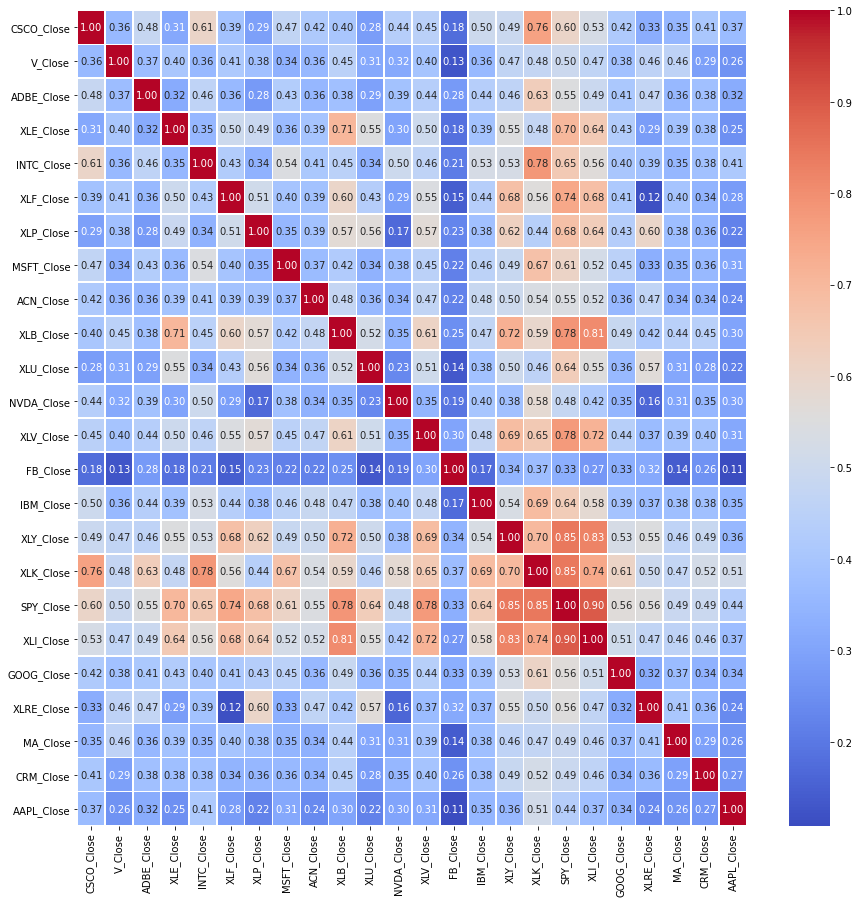

In [20]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(daily_return.corr(), annot=True,fmt = ".2f", cmap = "coolwarm", linewidths=.5, ax=ax)

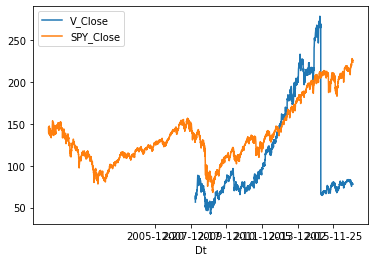

In [21]:
# Corr(V_Close, SPY_close) = 0.5
df['V_Close'].plot()
df['SPY_Close'].plot()
plt.legend()

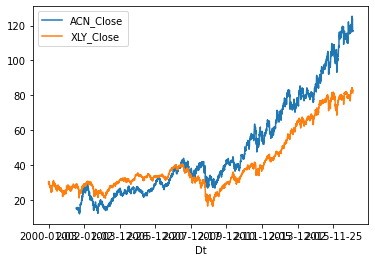

In [22]:
# Corr(ACN_Close,XLY_close) = 0.50
df['ACN_Close'].plot()
df['XLY_Close'].plot()
plt.legend()

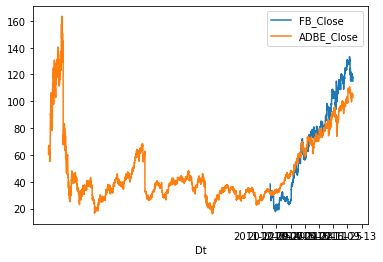

In [23]:
# Corr(FB_Close,ADBE_close) = 0.28
df['FB_Close'].plot()
df['ADBE_Close'].plot()
plt.legend()

# Classification task OR Regression task?

## rationale for regression
If we view this question as a regression task, what we are trying to achieve in the end from the previous data is the exact return/ close price for the next trading day, which is also what we are going to get tested for this project in the handout dataset.

One specific difficulty in regression task is that training a model will be hard. Given the daily return has numerical value between [1e-3, 1e-4], It's hard for us to define a measurement creteria for evaluation matrix eg. MSE, MAE.

The intuition behind this regression is the same as the regression task we did in homework 1. However, since this is a time seris data, we should be careful when construct train and test sets. The feature engineering should be another very important focus of this project.

## rationale for classification
If we view this question as a classification task, we can definitly get a decent result about which direction that AAPL will move in the next day from previous information. It should perfectly work for the situation when I am only asked to decided the next trading strategy (Long, Short, Hold). And it will, to some extent, solve the issue that might appear in regression model.

But how to predict the directions in the far future? You lost some important imformation by only predicting the direction instead of exact value of the return, which will disable you to get accurate predictions when you go further and further.

Since we are asked to predict the last 200 prices in holdout dataset, we should not use classification here. However, if we are implementing a trading strategy, classification should be a good choice to try out.

## Conclusions:
Should first try regression and see how models perform.

Some ideas about model choosing that directly pop out to my mind are:

DNN simplest neural network

CNN (convolutional neural network) to identify key features and patterns

LSTM (recurrent neural network) has better performance when given data follows a sequence.

# Start our experiment by only using features from historical AAPL Prices.

There are two ways of consturcting features from only historical AAPL prices in this case:

The first way is to have a sliding window of window size = X. Each entry in the window represent one feature and we end up having X number of features and one target value, which is the price of AAPL directly after the sliding window. 

The second way is to using a simple idea in technical analysis called moving average. Our final goal is to create a N * N feature matrix and we train a CNN on it. The feature matrix is constructed by N different sliding windows with {6, 7, 8, ..., 6 + N - 1}. For each sliding window, we get a total N moving average from historical data, which helps us construct the row of feature matrix. I will explore it more in the subsection where I dive into it.

In [24]:
def create_data_AAPL_first(window_size, stock):
    stocknew = stock.dropna()
    X_AAPL_first = None
    y_AAPL_first = None
    X_store = []
    y_store = []
    for i in range(stocknew.shape[0] - window_size):
        X_store.append(stocknew.values[i:i+window_size])
        y_store.append(stocknew[i+window_size])
    X_AAPL_first = np.array(X_store)
    y_AAPL_first = np.array(y_store)
    
    print(X_AAPL_first.shape)
    print(y_AAPL_first.shape)
    
    return X_AAPL_first, y_AAPL_first

def create_data_AAPL_second(matrix_length,starting_length, stock):
    stocknew = stock.dropna()
    max_length = starting_length + matrix_length - 1
    X_AAPL_second = None
    y_AAPL_second = None
    X_store = []
    y_store = []
    for i in range(stocknew.shape[0] - 2 * max_length + 1):
        matrix = []
        for j in range(matrix_length):
            length = starting_length + j # 6,7,8,9,10
            row = stocknew[i  + matrix_length - j - 1: i + max_length + matrix_length - 1].rolling(length).mean().values[-matrix_length:]
            matrix.append(row)
        X_store.append(matrix)
        y_store.append(stocknew[i+ 2 * max_length - 1])
    X_AAPL_second = np.array(X_store)
    y_AAPL_second = np.array(y_store)
    
    print(X_AAPL_second.shape)
    print(y_AAPL_second.shape)
    
    return X_AAPL_second, y_AAPL_second

def create_data_ALL(matrix_length,starting_length, stock_name, method):
    store = []
    X_ALL = None
    y_ALL = None
    for i in stock_name:
        data = daily_return[i]
        if method == 'second':
            X, y = create_data_AAPL_second(matrix_length,starting_length,data)
        else:
            X, y = create_data_AAPL_first(matrix_length,data)
        if i == 'AAPL_Close':
            y_ALL = y
        store.append(X[...,np.newaxis])
    if method == 'second':
        data = np.concatenate(store,axis = 3)
    else:
        data = np.concatenate(store,axis = 2)
    X_ALL = data
    return X_ALL,y_ALL

def split_train_test(Xdata,ydata,train_rate):
    # we are using first 80% of our historical data as train dataset and last 20% as our test dataset

    train_size = int(Xdata.shape[0]*train_rate)
    test_size = Xdata.shape[0] - train_size

    # split the historical data
    Xtrain = Xdata[:train_size,...]
    Xtest = Xdata[train_size:,...]

    ytrain = ydata[:train_size]
    ytest = ydata[train_size:]

    print('The shape of Xtrain dataset is: ',Xtrain.shape)
    print('The shape of Xtest dataset is: ',Xtest.shape)
    print('The shape of ytrain dataset is: ',ytrain.shape)
    print('The shape of ytest dataset is: ',ytest.shape)
    
    return Xtrain, Xtest, ytrain, ytest

def MinmaxScale(train,val,test,):
    scaler = MinMaxScaler(feature_range=(-1,1))
    train = scaler.fit_transform(train.reshape(-1,train.shape[-1])).reshape(train.shape)
    val = scaler.transform(val.reshape(-1,val.shape[-1])).reshape(val.shape)
    test = scaler.transform(test.reshape(-1,test.shape[-1])).reshape(test.shape)
    return train,val,test

def return2price(returns,starting_price):
    prices = starting_price * (1+returns).cumprod()
    return prices

## Construct train and test set

### First way, X# features and one target value

In [25]:
X_AAPL_first,y_AAPL_first = create_data_AAPL_first(200,daily_return['AAPL_Close'])

(4076, 200)
(4076,)


In [26]:
Xtrain, Xtest, ytrain, ytest = split_train_test(X_AAPL_first,y_AAPL_first,0.8)

The shape of Xtrain dataset is:  (3260, 200)
The shape of Xtest dataset is:  (816, 200)
The shape of ytrain dataset is:  (3260,)
The shape of ytest dataset is:  (816,)


In [27]:
Xtrain_1, Xval, ytrain_1, yval = split_train_test(Xtrain,ytrain,0.9)

The shape of Xtrain dataset is:  (2934, 200)
The shape of Xtest dataset is:  (326, 200)
The shape of ytrain dataset is:  (2934,)
The shape of ytest dataset is:  (326,)


In [28]:
Xtrain_1,Xval,Xtest = MinmaxScale(Xtrain_1,Xval,Xtest)

### model selection (simple Deep Neural Network)

In [29]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [30]:
modelDNN = None

input_shape = Xtrain_1[0].shape

num_features_1 = 1000
num_features_2 = 1000

modelDNN = models.Sequential()
modelDNN.add(layers.Dense(num_features_1, kernel_initializer='normal', activation = tf.nn.relu, name = 'dense_1',input_shape = input_shape))
modelDNN.add(layers.Dense(num_features_1, kernel_initializer='normal', activation=tf.nn.relu, name="dense_2"))
modelDNN.add(layers.Dropout(0.2))
modelDNN.add(layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_3"))
modelDNN.add(layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_4"))
modelDNN.add(layers.Dropout(0.2))

modelDNN.add(layers.Dense(1, kernel_initializer='normal', activation = 'linear' ,name = "dense_head"))

modelDNN.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              201000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_head (Dense)           (None, 1)                 1

In [31]:
modelDNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
modelDNN.fit(Xtrain_1, ytrain_1,batch_size = 128, epochs=50, validation_data=(Xval, yval))

Train on 2934 samples, validate on 326 samples
Epoch 1/50
2934/2934 [==============================] - 3s 1ms/sample - loss: 0.9686 - mean_absolute_error: 0.9686 - val_loss: 0.0927 - val_mean_absolute_error: 0.0927
Epoch 2/50
2934/2934 [==============================] - 2s 672us/sample - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 3/50
2934/2934 [==============================] - 2s 632us/sample - loss: 0.0237 - mean_absolute_error: 0.0237 - val_loss: 0.0143 - val_mean_absolute_error: 0.0143
Epoch 4/50
2934/2934 [==============================] - 2s 636us/sample - loss: 0.0219 - mean_absolute_error: 0.0219 - val_loss: 0.0136 - val_mean_absolute_error: 0.0136
Epoch 5/50
2934/2934 [==============================] - 2s 670us/sample - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0139 - val_mean_absolute_error: 0.0139
Epoch 6/50
2934/2934 [==============================] - 2s 670us/sample - loss: 0.0205 - mean_absolute_er

Epoch 49/50
2934/2934 [==============================] - 2s 676us/sample - loss: 0.0188 - mean_absolute_error: 0.0188 - val_loss: 0.0138 - val_mean_absolute_error: 0.0138
Epoch 50/50
2934/2934 [==============================] - 2s 696us/sample - loss: 0.0187 - mean_absolute_error: 0.0187 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137


In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [33]:
predict = modelDNN.predict(Xtest)
mean_squared_error(predict,ytest)

0.0011298866749304038

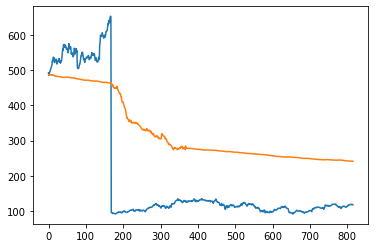

In [34]:
rettrue = return2price(ytest,df['AAPL_Close'][-ytest.shape[0]])
retpredict = return2price(predict,df['AAPL_Close'][-ytest.shape[0]])
plt.plot(rettrue)
plt.plot(retpredict)

## For Second way, I decided to use the Convolutional Neural Network

### Second way, N * N feature matrix image and one target value

In [35]:
X_AAPL_second,y_AAPL_second = create_data_AAPL_second(50,5,daily_return['AAPL_Close'])
Xtrain, Xtest, ytrain, ytest = split_train_test(X_AAPL_second,y_AAPL_second,0.8)

(4169, 50, 50)
(4169,)
The shape of Xtrain dataset is:  (3335, 50, 50)
The shape of Xtest dataset is:  (834, 50, 50)
The shape of ytrain dataset is:  (3335,)
The shape of ytest dataset is:  (834,)


In [36]:
Xtrain_1, Xval, ytrain_1, yval = split_train_test(Xtrain,ytrain,0.9)

The shape of Xtrain dataset is:  (3001, 50, 50)
The shape of Xtest dataset is:  (334, 50, 50)
The shape of ytrain dataset is:  (3001,)
The shape of ytest dataset is:  (334,)


In [37]:
Xtrain_1,Xval,Xtest = MinmaxScale(Xtrain_1,Xval,Xtest)

In [38]:
Xtrain_1 = Xtrain_1.reshape(Xtrain_1.shape[0],Xtrain_1.shape[1],Xtrain_1.shape[2],1)
Xval = Xval.reshape(Xval.shape[0],Xval.shape[1],Xval.shape[2],1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2],1)

In [39]:
input_shape = Xtrain_1[0].shape

modelCNN = None

num_features_1 = 500
num_features_2 = 500

modelCNN = models.Sequential( [ 
                       layers.Conv2D(64, kernel_size=(3,3),activation='relu',padding = 'same',input_shape=input_shape,name = 'conv1'),
                       layers.MaxPooling2D(pool_size=(2,2)),
                       layers.Conv2D(64, (3,3), activation='relu',padding = 'same',name = 'conv2'),
                       #layers.MaxPooling2D(pool_size=(2,2)),
                       layers.Conv2D(128, (3,3), activation='relu',padding = 'same',name = 'conv3'),
                       layers.Flatten(),
                       layers.Dense(num_features_1, kernel_initializer='normal', activation = tf.nn.relu, name = 'dense_1'),
                       layers.Dense(num_features_1, kernel_initializer='normal', activation=tf.nn.relu, name="dense_2"),
                       layers.Dropout(0.2),
                       layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_3"),
                       layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_4"),
                       layers.Dropout(0.2),

                       #layers.Dropout(0.5),
                       layers.Dense(1, kernel_initializer='normal', activation = 'linear' ,name = "dense_head")
  ]
)

modelCNN.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 50, 50, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 128)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 25, 25, 128)       147584    
_________________________________________________________________
conv3 (Conv2D)               (None, 25, 25, 128)       147584    
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               40000500  
_________________________________________________________________
dense_2 (Dense)              (None, 500)              

In [40]:
modelCNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
modelCNN.fit(Xtrain_1, ytrain_1, batch_size = 128, epochs=20, validation_data=(Xval, yval))

Train on 3001 samples, validate on 334 samples
Epoch 1/50
3001/3001 [==============================] - 51s 17ms/sample - loss: 0.1536 - mean_absolute_error: 0.1536 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 2/50
3001/3001 [==============================] - 48s 16ms/sample - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0135 - val_mean_absolute_error: 0.0135
Epoch 3/50
3001/3001 [==============================] - 48s 16ms/sample - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0137 - val_mean_absolute_error: 0.0137
Epoch 4/50
3001/3001 [==============================] - 49s 16ms/sample - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134
Epoch 5/50
3001/3001 [==============================] - 49s 16ms/sample - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134
Epoch 6/50
3001/3001 [==============================] - 49s 16ms/sample - loss: 0.0202 - mean_absolute_

KeyboardInterrupt: 

In [ ]:
predict= modelCNN.predict(Xtest)
mean_squared_error(predict,ytest)

In [ ]:
rettrue = return2price(ytest,df['AAPL_Close'][-ytest.shape[0]])
retpredict = return2price(predict,df['AAPL_Close'][-ytest.shape[0]])
plt.plot(rettrue)
plt.plot(retpredict)

## extending our models using more than AAPL

### CNN can perform perfectly on multi-dimensional input.

Intuition behind:

Same as the satellite ship project, where each picture has three color channels. We can include more information (eg. daily return of other stickers or indices) by constructing different channels for different stickers. 

For example, if we want to use AAPL, SPY, XLY as our three selected stickers, for each train-test case, we construct training input as a N * N * 3 3-dimentional matrix and set the target value same as we did for the second case in ONLY AAPL situation.

### Select some tickers to add in

From the heat map above, I select INTL, SPY, XLI, They have relatively high corr with AAPL and they are all in full rank, we do not loss any information.

In [ ]:
stock_name = ['INTC_Close','SPY_Close','XLI_Close','AAPL_Close']

In [ ]:
X_ALL, y_ALL= create_data_ALL(50,5,stock_name,method = 'second')

print('the shape of X_ALL is: ', X_ALL.shape)
print('the shape of y_ALL is: ', y_ALL.shape)

In [ ]:
Xtrain, Xtest, ytrain, ytest = split_train_test(X_ALL,y_ALL,0.8)
Xtrain_1, Xval, ytrain_1, yval = split_train_test(Xtrain,ytrain,0.9)

In [ ]:
Xtrain_1,Xval,Xtest = MinmaxScale(Xtrain_1,Xval,Xtest)

In [ ]:
input_shape = Xtrain_1[0].shape

modelCNN_ALL = None

num_features_1 = 1000
num_features_2 = 1000

modelCNN_ALL = models.Sequential( [ 
                       layers.Conv2D(128, kernel_size=(3,3),activation='relu',padding = 'same',input_shape=input_shape,name = 'conv1'),
                       layers.MaxPooling2D(pool_size=(2,2)),
                       layers.Conv2D(128, (3,3), activation='relu',padding = 'same',name = 'conv2'),
                       layers.Conv2D(128,(2,2), activation='relu',padding = 'same',name = 'conv3'),
                       layers.Flatten(),
                       layers.Dense(num_features_1, kernel_initializer='normal', activation = tf.nn.relu, name = 'dense_1'),
                       layers.Dense(num_features_1, kernel_initializer='normal', activation=tf.nn.relu, name="dense_2"),
                       layers.Dropout(0.2),
                       layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_3"),
                       layers.Dense(num_features_2, kernel_initializer='normal', activation=tf.nn.relu, name="dense_4"),
                       layers.Dropout(0.2),

                       #layers.Dropout(0.5),
                       layers.Dense(1, kernel_initializer='normal', activation = 'linear' ,name = "dense_head")
  ]
)

modelCNN_ALL.summary()

In [ ]:
modelCNN_ALL.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
modelCNN_ALL.fit(Xtrain_1, ytrain_1, batch_size = 128, epochs=100, validation_data=(Xval, yval))

In [ ]:
predict= modelCNN_ALL.predict(Xtest)
mean_squared_error(predict,ytest)

In [ ]:
rettrue = return2price(ytest,df['AAPL_Close'][-ytest.shape[0]])
retpredict = return2price(predict,df['AAPL_Close'][-ytest.shape[0]])
plt.plot(rettrue)
plt.plot(retpredict)

# Recurrent Neural Network

## generate train and test dataset

In [ ]:
# since we are using LSTM here, we must have a sequence of input
# we can continue to use our 
# X_AAPL_first_train,y_AAPL_first_trainX_AAPL_first_test,y_AAPL_first_test
# since we already standardize it, there is no need to redo it.

X_AAPL_first,y_AAPL_first = create_data_AAPL_first(200,daily_return['AAPL_Close'])
Xtrain, Xtest, ytrain, ytest = split_train_test(X_AAPL_first,y_AAPL_first,0.8)
Xtrain_1, Xval, ytrain_1, yval = split_train_test(Xtrain,ytrain,0.9)
Xtrain_1,Xval,Xtest = MinmaxScale(Xtrain_1,Xval,Xtest)

In [ ]:
# in order to use LSTM, convert input into shape [sample, time_step, features]

Xtrain_1 = Xtrain_1.reshape(Xtrain_1.shape[0],Xtrain_1.shape[1],1)
Xval = Xval.reshape(Xval.shape[0],Xval.shape[1],1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)

print(Xtrain_1.shape)
print(Xtest.shape)
print(Xval.shape)

## Create the most basic LSTM

In [ ]:
def LSTMModel(input_shape):
    model = models.Sequential()
    # inorder to use stacked LSTM, we must keep the sequence pattern before we pass it to next LSTM layer.
    model.add(layers.LSTM(100,return_sequences=True, input_shape=input_shape)) 
    model.add(layers.LSTM(100,return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(100,input_shape=input_shape))

    model.add(layers.Dense(1,name = "dense_head"))
    
    return model

def plotModel(model, modelName):
    plotFile = modelName + ".png"
    plot_model(model, plotFile, show_shapes=True)
    
    return plotFile

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
input_shape = Xtrain_1[0].shape
model_name = 'LSTM_model'

modelLSTM = LSTMModel(input_shape)
plt = plotModel(modelLSTM,'LSTM')

optimizer = RMSprop(lr=0.01)
# we are defining both the Loss function and evaluation matrics to be mean_abs_error
modelLSTM.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])# , optimizer = optimizer)

IPython.display.Image(plt) 

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.000005, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
callbacks = [ es_callback,
              tf.keras.callbacks.ModelCheckpoint(filepath= model_name + ".ckpt", monitor='mean_absolute_error', save_best_only=True)
          ]

In [ ]:
modelLSTM.fit(Xtrain_1, ytrain_1,
          batch_size=128,
          epochs=100,
          callbacks=callbacks,
          validation_data=(Xval, yval))

In [ ]:
predict = modelLSTM.predict(Xtest)
mean_squared_error(predict,ytest)

In [ ]:
rettrue = return2price(ytest,df['AAPL_Close'][-ytest.shape[0]])
retpredict = return2price(predict,df['AAPL_Close'][-ytest.shape[0]])
plt.plot(rettrue)
plt.plot(retpredict)

## extending model features by including more tickers

In [ ]:
stock_name = ['INTC_Close','SPY_Close','XLI_Close','AAPL_Close']

In [ ]:
AAPL_first_X_ALL, AAPL_first_y_ALL = create_data_ALL(matrix_length = 200,starting_length = None, stock_name = stock_name, method = 'first')

In [ ]:
print("The shape of AAPL_first_X_ALL is: ", AAPL_first_X_ALL.shape)
print("The shape of AAPL_first_y_ALL is: ", AAPL_first_y_ALL.shape)

In [ ]:
Xtrain, Xtest, ytrain, ytest = split_train_test(AAPL_first_X_ALL,AAPL_first_y_ALL,0.8)
Xtrain_1, Xval, ytrain_1, yval = split_train_test(Xtrain,ytrain,0.9)
Xtrain_1,Xval,Xtest = MinmaxScale(Xtrain_1,Xval,Xtest)

In [ ]:
input_shape = Xtrain_1[0].shape
model_name = 'LSTM_model_ALL'

modelLSTM_ALL = LSTMModel(input_shape)
plt = plotModel(modelLSTM_ALL,'LSTM')

optimizer = RMSprop(lr=0.01)
# we are defining both the Loss function and evaluation matrics to be mean_abs_error
modelLSTM_ALL.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])# , optimizer = optimizer)

IPython.display.Image(plt) 

In [ ]:
modelLSTM_ALL.fit(Xtrain_1, ytrain_1,
          batch_size=128,
          epochs=100,
          callbacks=callbacks,
          validation_data=(Xval, yval))

In [ ]:
predict = modelLSTM_ALL.predict(Xtest)
mean_squared_error(predict,ytest)

In [ ]:
rettrue = return2price(ytest,df['AAPL_Close'][-ytest.shape[0]])
retpredict = return2price(predict,df['AAPL_Close'][-ytest.shape[0]])
plt.plot(rettrue)
plt.plot(retpredict)

# Extension of CNN by constructing a different input matrix (image)

Intuition:

As I mentioned in the previous section, we constructed a N * N input matrix (image) by computing various Moving Averages for different period. There is absolutly some redundancy and dependency between features, since they are all Moving Averages that we get from historical Close price.

The more reasonable idea is to use different technical indicators for example:

Relative Strength Index, Money Flow Index, Stochastics, MACD and Bollinger Bands and so on.

Also, we can create some boolean features to implement the techinical analysis strategy in order to help model predict the directions of stock movement. For example, we know when Moving average short term crosspass a Moving average long term, it means bullish. In the other direction, it means bearish.

Hope that our new CNN model can extract more features representing main strength of Fundamental analysis

## Start from AAPL, we want to get some technical indicators.

In [ ]:
import talib

In [ ]:
ta.add_all_ta_features??

In [ ]:
# load the data again
DATA_DIR = "./Data/train"

# list all the tickers we want
tickers = []

# the target index we want to predict is AAPL
indx = 'AAPL'

# we are using Close price to determine our return.
attr = ['Adj Close','Close','Div','High','Low','Open','Volume']

AAPL_df = getData(tickers,indx,attr, DATA_DIR)

print("Date shape: ", AAPL_df.shape)

In [ ]:
AAPL_df

In [ ]:
def get_MA(df,window_size,ticker_name):
    for length in window_size:
        df['MA' + '_' + str(length)] = df[ticker_name + '_Close'].rolling(length).mean()
    return df

def get_ExpMA(df,window_size,ticker_name):
    for length in window_size:
        df['ExpMA' + '_' + str(length)] = df[ticker_name + '_Close'].ewm(span = length, adjust = False).mean()
    return df

def get_BBands(df,window_size,ticker_name):
    for length in window_size:
        rolling_mean = df[ticker_name + '_Close'].rolling(length).mean()
        rolling_std = df[ticker_name + '_Close'].rolling(length).std()
        df['Upper_BBand_' + str(length)] = rolling_mean + 2 * rolling_std
        df['Lower_BBand_' + str(length)] = rolling_mean - 2 * rolling_std
    return df

def get_MACD(df,window_size1,window_size2,ticker_name):
    expma1 = df[ticker_name + '_Close'].ewm(span = window_size1, adjust = False).mean()
    expma2 = df[ticker_name + '_Close'].ewm(span = window_size2, adjust = False).mean()
    df['MACD' + '_' + str(window_size1) + '_' + str(window_size2)] = expma2 - expma1
    return df
    

In [ ]:
window_size = [5,10,20,30,60]
get_MA(AAPL_df,window_size,'AAPL')
get_ExpMA(AAPL_df,window_size,'AAPL')